# Tuango - RFM Analysis for Mobile App Push Messaging

In this notebook, I am going to analyse the tuango dataset, which contains order data of 278,780 customers.

I answered the following questions:

1. What percentage of customers responded after the push message?
2. Who to send push notification based on different targeting strategy based on RFM methodology?
2. What is the projected ROME(Return on Marketing Expenditure) of 5 different targeting strategy?
3. What is the actual ROME of 5 different targeting strategy?

In [3]:
#  import python packages that
# are already part of the docker container
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns


In [4]:
tuango = pd.read_pickle("data/tuango_pre.pkl")

## Part I:  Preliminary and Quintile Analysis 

### What percentage of customers responded (i.e., bought anything) after the push message?

In [5]:
# insert calculation code here
# the result should be expressed as a percentage as a string with 2 decimal 
# places and assigned to q1 (e.g., q1 = '5.43%')

q1 = round((sum(tuango.buyer == 'yes')*100)/27878,2) 
print(q1,'% percentage of customers responded')

2.98 % percentage of customers responded



### What was the average amount spent on the Karaoke deal by customers that bought one (or more)? Use the `ordersize` variable for your calculation

In [7]:
# insert calculation code here to create a pd.pivot_table that shows
# (1) counts the number of yes and no, (2) the mean ordersize, and 
# (3) the standard deviation in ordersize for yes and no responses
q2 = pd.pivot_table(tuango, values="ordersize",index = 'buyer',
                     aggfunc= ['mean','count','std'])

# the below should show your result
q2.loc["yes", "mean"]

ordersize    202.128761
Name: yes, dtype: float64

### Create independent quintile variables for recency, frequency and monetary

In [8]:
# insert calculation code to add columns `rec_iq`, `freq_iq`, and `mon_iq`
# to the `tuango` DataFrame
# Hint: You can also use the 'assign' method for DataFrames to add multiple
# varialbes in one step

tuango["rec_iq"] = rsm.xtile(tuango['recency'],5)
tuango["freq_iq"] = rsm.xtile(tuango['frequency'],5,rev = True)
tuango["mon_iq"] = rsm.xtile(tuango['monetary'],5,rev = True)

### Bar charts showing the response rate for this deal per (independent) recency, frequency, and monetary quintile

> Note:the 1st quantile contains the best customers for each variable you create

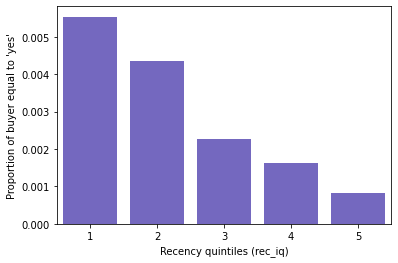

In [9]:
fig = rsm.prop_plot(tuango, "rec_iq", "buyer", "yes")
fig = fig.set(xlabel="Recency quintiles (rec_iq)")

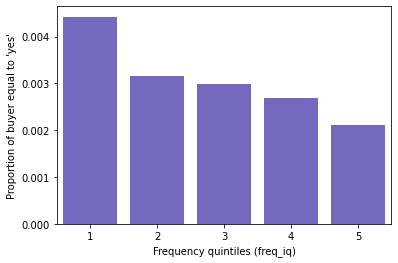

In [10]:
fig = rsm.prop_plot(tuango, "freq_iq", "buyer", "yes")
fig = fig.set(xlabel="Frequency quintiles (freq_iq)")

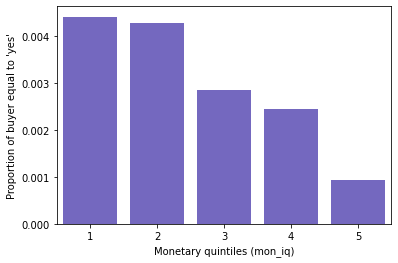

In [11]:
fig = rsm.prop_plot(tuango, "mon_iq", "buyer", "yes")
fig = fig.set(xlabel="Monetary quintiles (mon_iq)")

### Bar charts showing the average amount spent (in RMB)per independent recency, frequency, and monetary quintile using only those customers who placed an order after the push message



<AxesSubplot:xlabel='rec_iq', ylabel='ordersize'>

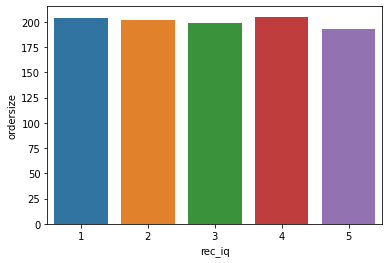

In [11]:
recen =pd.DataFrame(tuango[tuango['buyer'] == 'yes'].groupby('rec_iq')['ordersize'].mean()).reset_index()
sns.barplot(x = 'rec_iq',y = "ordersize",data = recen)

<AxesSubplot:xlabel='mon_iq', ylabel='ordersize'>

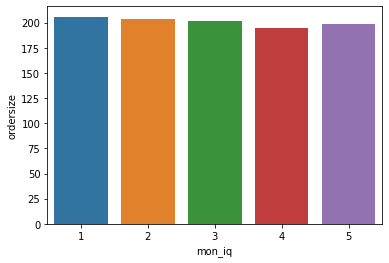

In [12]:
mon =pd.DataFrame(tuango[tuango['buyer'] == 'yes'].groupby('mon_iq')['ordersize'].mean()).reset_index()
sns.barplot(x = 'mon_iq',y = "ordersize",data = mon)

<AxesSubplot:xlabel='freq_iq', ylabel='ordersize'>

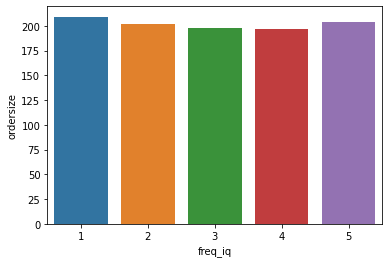

In [13]:
freq =pd.DataFrame(tuango[tuango['buyer'] == 'yes'].groupby('freq_iq')['ordersize'].mean()).reset_index()
sns.barplot(x = 'freq_iq',y = "ordersize",data = freq)

### What do the above bar charts reveal about the likelihood of response and the size of the order across the different recency, frequency, and monetary quintiles?

Based on first 3 graphs, there are obvious differences about the response rate across different recency, frequency and monetary quintiles. Group 1 has the highest response rate and group 5 has the lowest. While regarding the size of order(last 3 graphs), the difference across different quintiles is not significant and Group 1-5 have similar average ordersize. A possible reason is that there is only 3 deals (1,2,or 3-hour Karaoke session, which were priced at 129RMB, 209RMB, and 259RMB) and price differences of them are not huge.

## Part II: Profitability Analysis 

### What is the breakeven response rate?

In [18]:
# state your assumptions relevant to calculate the breakeven response rate
# breakeven should be of type `float`

cost = 2.5 # float, length 1,cost of contacting a customer
margin = 0.5*q2.loc["yes", "mean"][0] # float, length 1, margin of the revenue
breakeven = cost/margin # float, length 1
q7 = breakeven
q7

0.02473670736862159

### What is the projected profit in RMB and the return on marketing expenditures if offer the deal to all 250,902 remaining customers?

In [19]:
# insert calculation code here
# all variables should be numeric (integer or float) and of length 1
# _nt stands for 'no targeting'

nr_sms_nt = 250902# total number of SMSs that would be sent out
sms_cost_nt = nr_sms_nt* cost # total cost in RMB (no rounding)
nr_responses_nt = (sum(tuango.buyer == 'yes'))/27878*nr_sms_nt # total number of positive responses
response_rate_nt = (sum(tuango.buyer == 'yes'))/27878# expressed as a proportion (no rounding)
revenue_nt = nr_responses_nt*q2.loc["yes", "mean"][0]# total revenue in RMB (no rounding)
profit_nt = revenue_nt*0.5 - sms_cost_nt # total profit in RMB (no rounding)
ROME_nt = profit_nt/sms_cost_nt # Return on Marketing Expenditures expressed as a proportion (no rounding)

In [20]:
ROME_nt

0.20502905516895042

### Evaluate the performance implications of offering the deal to only those customers (out of 250,902) in RFM cells with a response rate greater than the breakeven response rate

Generate your result based on both sequential and independent RFM. Determine the projected profit in RMB and the return on marketing expenditures for each approach

In [21]:
# add `rfm_iq` to the tuango dataset
tuango["rfm_iq"] =  tuango.rec_iq.astype(str) + tuango.freq_iq.astype(str) + tuango.mon_iq.astype(str)

In [22]:
# determine which customers to sms based on independent quintiles RFM
exp =tuango[:27878]
send = pd.DataFrame().assign(number = exp.groupby('rfm_iq')['userid'].count(),
                    buy = exp[exp['buyer'] == 'yes'].groupby('rfm_iq')['userid'].count())
send['rate'] = send['buy']/send['number']
send = send.fillna(0)
iqlist = list(send[send['rate']> q7].index) #list of iq rfm that has response rate > breakeven

In [23]:
def sendmail(iq,iqlist):
    if iq in iqlist:
        return 1
    else:
        return 0

In [24]:
tuango["smsto_iq"] = tuango.apply(lambda x: sendmail(x['rfm_iq'],iqlist),axis=1)

In [25]:
# insert calculation code to add columns `freq_sq`, and `mon_sq`
# to the `tuango` DataFrame
# Note that pandas `assign` method doesn't allow you to use variables created in the same call to assign
tuango["freq_sq"] = tuango.groupby("rec_iq").frequency.transform(rsm.xtile, 5, rev=True)
tuango["mon_sq"] = tuango.groupby(["rec_iq", "freq_sq"]).monetary.transform(rsm.xtile, 5, rev=True)

In [26]:
# add `rfm_sq` to the tuango dataset
tuango["rfm_sq"] = tuango.rec_iq.astype(str) + tuango.freq_sq.astype(str) + tuango.mon_sq.astype(str)

In [27]:
exp =tuango[:27878]
send2 = pd.DataFrame().assign(number = exp.groupby('rfm_sq')['userid'].count(),
                    buy = exp[exp['buyer'] == 'yes'].groupby('rfm_sq')['userid'].count())
send2['rate'] = send2['buy']/send2['number']
send2 = send2.fillna(0)

In [28]:
sqlist = list(send2[send2['rate']> q7].index) #list of sq rfm that has response rate > breakeven

In [29]:
# determine which customers to sms based on sequential quintiles RFM
tuango["smsto_sq"] = tuango.apply(lambda x: sendmail(x['rfm_sq'],sqlist),axis=1)
tuango["buyer_yes"] = rsm.ifelse(tuango.buyer == "yes", 1, 0)

In [30]:
exp =tuango[:27878]
resp_iq = exp.groupby("smsto_sq").buyer_yes.agg(["count", "sum", "mean"])

In [31]:
# write your perf_calc function here (see the tuango.pdf document for suggestions)
def perf_calc(dat=tuango, smsto=None, intro="", perf="buyer", lev="yes"):
    """
    Calculate projected performance implications from using different 
    targeting strategies
    Parameters
    ----------
    dat : Pandas DataFrame
        Pass the tuango dataset as the default value
    smsto : str
        A string with the name of the 'smsto' variable to use for calculations
    intro : str
        A string that provides an introduction to the printed output
    perf: str
        A string with the name of the performance variable to use ('buyer')
    lev: str
        A string with the name of the level in the perf variable that signifies success ('yes')

    Returns
    -------
    nr_sms : Total number of SMSs that would be sent out
    sms_cost : Total revenue in RMB (no rounding)
    nr_responses : Total number of positive responses
    response_rate : Expressed as a proportion (no rounding)
    revenue : Total revenue in RMB (no rounding)
    ROME : Return on Marketing Expenditures expressed as a proportion (no rounding)
    profit : Total profit in RMB (no rounding)
    """
    exp =tuango[:27878] #experiment data
    dat = dat[27878:] #remaining data
    if smsto == None:
        nr_sms = 250902
        response_rate_nt = sum(tuango[tuango['training']== 1].buyer == 'yes')/27878
    else:
        nr_sms = dat[smsto].sum()
        resp_iq = exp.groupby(smsto).buyer_yes.agg(["count", "sum", "mean"])
        resp_iq.columns = ["n_obs", "n_buyers", "perc"]
        response_rate_nt = resp_iq.iloc[1,2]
        
     # total number of SMSs that would be sent out
    sms_cost = nr_sms* 2.5  # total cost in RMB (no rounding)
    nr_responses = response_rate_nt*nr_sms # total number of positive responses
    revenue_nt = nr_responses*q2.loc["yes", "mean"][0]    # total revenue in RMB (no rounding)
    profit_nt = revenue_nt*0.5 - sms_cost # total profit in RMB (no rounding)
    ROME_nt = profit_nt/sms_cost # Return on Marketing Expenditures expressed as a proportion (no rounding)
    
    print(intro,
    ':\nTotal number of SMSs that would be sent out :',nr_sms, #Total number of SMSs that would be sent out
    "\nTotal cost in RMB :" ,sms_cost , #Total revenue in RMB (no rounding)
    "\nTotal number of positive responses :", nr_responses, #Total number of positive responses
    "\nresponse_rate :",response_rate_nt, #Expressed as a proportion (no rounding)
    "\nTotal revenue in RMB :",revenue_nt, #Total revenue in RMB (no rounding)
   "\nReturn on Marketing Expenditures :" , ROME_nt,#Return on Marketing Expenditures expressed as a proportion (no rounding)
    "\nTotal profit :",profit_nt, #Total profit in RMB (no rounding)，
          "\nROME:", round(100 * ROME_nt, 3), "%"
        )
    
    return nr_sms, sms_cost, nr_responses, response_rate_nt, revenue_nt, ROME_nt, profit_nt

In [32]:
# re-calculate performance for the no-targeting approach - should give same results as above
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _nt stands for 'no targeting'

nr_sms_nt, sms_cost_nt, nr_responses_nt, response_rate_nt, revenue_nt, ROME_nt, profit_nt = perf_calc(intro="If Tuango does not apply targeting")





If Tuango does not apply targeting :
Total number of SMSs that would be sent out : 250902 
Total cost in RMB : 627255.0 
Total number of positive responses : 7479.0 
response_rate : 0.02980845110840089 
Total revenue in RMB : 1511721.0 
Return on Marketing Expenditures : 0.20502905516895042 
Total profit : 128605.5 
ROME: 20.503 %


In [33]:
# calculate performance for independent RFM
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _iq stands for 'independent quintiles'
nr_sms_iq, sms_cost_iq, nr_responses_iq, response_rate_iq, revenue_iq, ROME_iq, profit_iq = perf_calc(smsto = 'smsto_iq',intro="If Tuango applies independent RFM targeting")

If Tuango applies independent RFM targeting :
Total number of SMSs that would be sent out : 111656 
Total cost in RMB : 279140.0 
Total number of positive responses : 6042.263810597519 
response_rate : 0.05411499436302142 
Total revenue in RMB : 1221315.2948282247 
Return on Marketing Expenditures : 1.1876393473314908 
Total profit : 331517.64741411235 
ROME: 118.764 %


In [34]:
# calculate performance for sequential RFM
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _sq stands for 'sequential quintiles'

nr_sms_sq, sms_cost_sq, nr_responses_sq, response_rate_sq, revenue_sq, ROME_sq, profit_sq =perf_calc(smsto = 'smsto_sq',intro="If Tuango applies sequential RFM targeting")

If Tuango applies sequential RFM targeting :
Total number of SMSs that would be sent out : 101321 
Total cost in RMB : 253302.5 
Total number of positive responses : 5837.165575221239 
response_rate : 0.05761061946902655 
Total revenue in RMB : 1179859.0427248331 
Return on Marketing Expenditures : 1.3289526213220026 
Total profit : 336627.02136241656 
ROME: 132.895 %


### Insights when comparing the `rfm_iq` and `rfm_sq` variables. Do the two approaches generally yield the same RFM index for any given customer? What are the pros and cons of the two approaches?

In [35]:
# insert any calculation or plotting code here
(len(tuango) -(tuango['rfm_iq'] == tuango['rfm_sq']).sum() )/ len(tuango)

0.3689396656862042

As we can see from the above calculation: 36% of the total customers have different RFM index.
For the sequential RFM index: 
A simple rank is assigned to recency values. Within each recency rank, customers are then assigned a frequency rank, and within each frequency rank, customer are assigned a monetary rank.This methodology could provide a more even distribution of combined RFM scores, but it make frequency and monetary rank scores harder to interpret.

For the independent RFM index: 
Ranks are assigned to recency, frequency, and monetary values independently. The interpretation of each of the three RFM components is therefore more straightforward.However, this may cause less even RFM distribution. 

###  Redo the previous analysis for sequential RFM based on a breakeven response rate calculated for each RFM cell. 

In [39]:
exp =tuango[:27878]
new = exp[exp["buyer_yes"] == 1].groupby("rfm_sq").ordersize.agg(["count", "sum", "mean"])

In [40]:
sq_rate = exp.groupby("rfm_sq").buyer_yes.agg(["count", "sum", "mean"])

In [41]:
def calordersize(x,df):
    if x not in df.index:
        return 0
    else:
        return df.loc[x,'mean']

In [42]:
# calculate the average ordersize per sq code
tuango["avg_ordersize_sq"] = tuango.apply(lambda x: calordersize(x['rfm_sq'],new),axis=1)
tuango["responsert_sq"] = tuango.apply(lambda x: sq_rate.loc[x['rfm_sq'],'mean'],axis=1)

In [44]:
# calculate a breakeven value per sq code
tuango["breakeven_pc"] = np.select([tuango['avg_ordersize_sq']==0,tuango['avg_ordersize_sq']!=0],[0,2.5/(0.5*tuango['avg_ordersize_sq'])])


In [45]:
# calculate the smsto variable based on breakeven value per sq code
# _pcsq stands for 'per cell sequential quintiles'

tuango["smsto_pcsq"] = tuango["responsert_sq"]>tuango["breakeven_pc"]


In [46]:
# calculate performance for break-even-per-cell sequential RFM
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _pcsq stands for 'per cell sequential quintiles'

nr_sms_pcsq, sms_cost_pcsq, nr_responses_pcsq, response_rate_pcsq, revenue_pcsq, ROME_pcsq, profit_pcsq = perf_calc(smsto="smsto_pcsq", intro="Based on sequential RFM with breakeven per cell"
)

Based on sequential RFM with breakeven per cell :
Total number of SMSs that would be sent out : 110617 
Total cost in RMB : 276542.5 
Total number of positive responses : 6052.729815175097 
response_rate : 0.054717898832684825 
Total revenue in RMB : 1223430.7753611864 
Return on Marketing Expenditures : 1.2120122139656406 
Total profit : 335172.8876805932 
ROME: 121.201 %


### The response rate for each cell is an estimated quantity (i.e., it has a standard error). Redo the analysis for both independent RFM,  the standard error of the response rate in each cell

In [47]:
tg_lbiq = (
    exp.groupby("rfm_iq").buyer_yes
    .agg(n_obs="count", prop=np.mean, se=rsm.seprop)
    .reset_index()
)

In [48]:
tg_lbiq = tg_lbiq.assign(prop_lb=tg_lbiq.prop - 1.64 * tg_lbiq.se)
tg_lbiq = tg_lbiq.set_index("rfm_iq")

In [49]:
tg_lbsq = (
    exp.groupby("rfm_sq").buyer_yes
    .agg(n_obs="count", prop=np.mean, se=rsm.seprop)
    .reset_index()
)
tg_lbsq = tg_lbsq.assign(prop_lb=tg_lbsq.prop - 1.64 * tg_lbsq.se)
tg_lbsq = tg_lbsq.set_index("rfm_sq")

In [50]:
tuango["smsto_lbsq"] = tuango.apply(lambda x: tg_lbsq.loc[x['rfm_sq'],'prop_lb']>q7,axis=1)

In [51]:
# calculate the performance for lower bound with sequential quintiles
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _lbsq stands for 'lower bound with sequential quintiles'

nr_sms_lbsq, sms_cost_lbsq, nr_responses_lbsq, response_rate_lbsq, revenue_lbsq, ROME_lbsq, profit_lbsq = perf_calc(
    smsto="smsto_lbsq",
    intro="Based on sequential RFM adjusted for response rate prediction accuracy",
)

Based on sequential RFM adjusted for response rate prediction accuracy :
Total number of SMSs that would be sent out : 54974 
Total cost in RMB : 137435.0 
Total number of positive responses : 4083.4246619970677 
response_rate : 0.07427919856654178 
Total revenue in RMB : 825377.5656449886 
Return on Marketing Expenditures : 2.0027924678756817 
Total profit : 275253.7828224943 
ROME: 200.279 %


In [52]:
# insert calculation code here - you do not need to do this 'per cell'
# _lbiq stands for 'lower bound independent quintiles'

tuango["smsto_lbiq"] = tuango.apply(lambda x: tg_lbiq.loc[x['rfm_iq'],'prop_lb'] > q7,axis=1)

In [53]:
# calculate the performance for lower bound with independent quintiles
# note that your perf_calc function should return values for each of the variables
# listed below
# all variables should be numeric (integer or float) and of length 1
# _lbiq stands for 'lower bound with independent quintiles'

nr_sms_lbiq, sms_cost_lbiq, nr_responses_lbiq, response_rate_lbiq, revenue_lbiq, ROME_lbiq, profit_lbiq = perf_calc(
    smsto="smsto_lbiq",
    intro="Based on independent RFM adjusted for response rate prediction accuracy",
)

Based on independent RFM adjusted for response rate prediction accuracy :
Total number of SMSs that would be sent out : 54445 
Total cost in RMB : 136112.5 
Total number of positive responses : 4116.178606800924 
response_rate : 0.07560250907890392 
Total revenue in RMB : 831998.079910643 
Return on Marketing Expenditures : 2.05628829060756 
Total profit : 279886.5399553215 
ROME: 205.629 %


### 13.	Create a bar chart with profit information and a bar chart with ROME numbers for the analyses conducted in questions 9, 11, and 12

In [54]:
# the below DataFrame should collect all performance information you created above
plot_data = pd.DataFrame(
    {
        "name": [
            "No targeting",
            "Indep. RFM",
            "Seq. RFM",
            "Seq. PC RFM",
            "Indep. LB RFM",
        ],
        "Profit": [
            profit_nt,
            profit_iq,
            profit_sq,
            profit_pcsq,
            profit_lbiq,
        ],
        "ROME": [ROME_nt, ROME_iq, ROME_sq, ROME_pcsq, ROME_lbiq],
    }
)

In [55]:
plot_data

,name,Profit,ROME
0,No targeting,128605.500000,0.205029
1,Indep. RFM,331517.647414,1.187639
2,Seq. RFM,336627.021362,1.328953
3,Seq. PC RFM,335172.887681,1.212012
4,Indep. LB RFM,279886.539955,2.056288


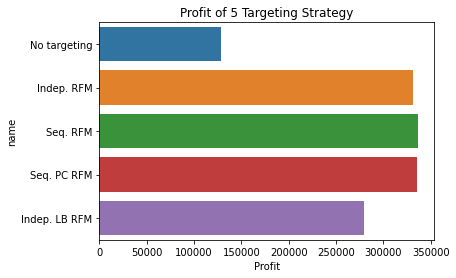

In [65]:
# insert code for the profit plot based on the 'plot_data' DataFrame
grph = sns.barplot(x = 'Profit', y = 'name',data = plot_data).set(title = 'Profit of 5 Targeting Strategy')

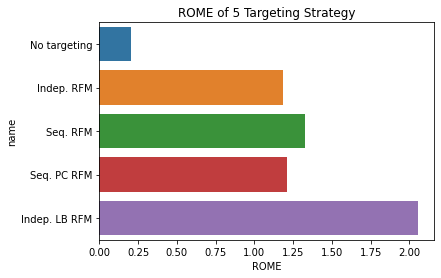

In [66]:
# insert code for the ROME plot based on the 'plot_data' DataFrame
grph = sns.barplot(x = 'ROME', y = 'name',data = plot_data).set(title = 'ROME of 5 Targeting Strategy')

### Question 14

Make a copy of the current notebook `tuango-pre.ipynb` and name the copy `tuango-post.ipynb`. You also have access to a dataset with the results from the SMS roll-out (`tuango_post.pkl`). Tuango actually contacted all 250,902 customers. The data has a "training" variable (training = 1 for the data used in the test, training = 0 for the remaining customers). You can use this variable to help evaluate the actual performance for each of the different RFM approaches. Re-create the plot in question 13 based on this new dataset. 

Instead of using the `tuango_pre.pkl` data, use `tuango_post.pkl`. You should be able to re-use most of your code and text. Create a new function `perf_calc_actual` that calculates the actual performance for each targeting approach on the 'roll out' sample (i.e., training == 0). Also, keep your `perf_calc` and use it to check that this still calculates the same values you were seeing before based on the `tuango-pre.pkl` data. The `perf_calc_actual` function will be similar to `perf_calc` but you will need to make some changes to determine the actual outcomes. Also make sure to check that your `rfm_iq` variable is the same as `rfm_iq_pre` in the `tuango_post.pkl` dataset.

> Hint: It is important that you do NOT use any information about buyers that were in the 'roll out' sample (i.e., training == 0) when calculating the break-even response rate etc. for targeting. 

Please see the new `perf_calc_actual` function and actual performance number of the 5 targeting strategy in the file `tuango-post.ipynb`